In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import time
import pandas as pd
import seaborn
import matplotlib.pyplot as plt

import pybnb
from transformers import *

from brute_force_warped_pvar import *
from branch_and_bound_warped_pvar import BnBWarping

# Define paths and set problem parameters

In [19]:
n_points = 12

x = np.sin(np.linspace(0, 2*np.pi, n_points-2))
y = np.cos(np.linspace(0, 3*np.pi, n_points))

x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

depth = 2
p = 1.35
norm = 'l1'

# Brute force algorithm

In [16]:
LP_seq = BruteForceWarpedPvar(x, y, p=p, depth=depth, norm=norm, augment=False, add_time=False, parallelise=False, 
                              optim_partition=True, pvar_advanced=False)

time to find all possible paths: 0.01


Loop over all warps: 100%|█████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 2015.11it/s]


total time for brute force with DP sequentially: 0.12 s


In [17]:
print('warped p-var: {:.2f}'.format(LP_seq.warped_pvar))
print('best warp: {}'.format(LP_seq.best_warp))
print('best partition: {}'.format(LP_seq.best_partition))

warped p-var: 7.81
best warp: [(0, 0), (0, 1), (0, 2), (1, 3), (1, 4), (2, 5), (3, 5), (3, 5), (3, 5)]
best partition: [0, 2, 3, 8]


# Branch and Bound algorithm

warped p-var: 8.99
wall time: 6.53 secs 

best_warp: [(0, 0), (1, 1), (2, 1), (3, 1), (4, 2), (5, 2), (6, 3), (7, 4), (8, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11)] 



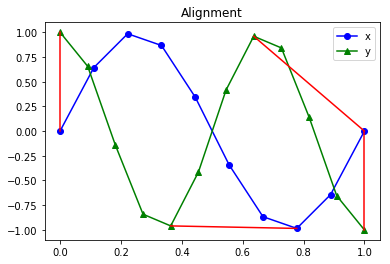

In [20]:
problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=3, plot_2d=True, pvar_advanced=False)

solver = pybnb.Solver()

results = solver.solve(problem, log=None, queue_strategy='depth')
# results = solver.solve(problem, log=None, queue_strategy='breadth')
# results = solver.solve(problem, log=None, queue_strategy=('depth', 'random'))

print('warped p-var: {:.2f}'.format(results.objective))
print('wall time: {:.2f} secs \n'.format(results.wall_time))

best_warp = results.best_node.state
print('best_warp: {} \n'.format(best_warp[1:]))
_, optimal_partition = problem.distance(results.best_node.state, optim_partition=True)
problem.plot_alignment([best_warp[k] for k in optimal_partition])
plt.show()

# Hyperparameter tuning (mainly p & boundary condition)

In [ ]:
# hyper-parameters
pvars = [1., 1.05, 1.2, 1.5, 2., 3.]
boundary_conditions = [1, 2, 3, 4, 5]

# values to be stored
final_times = {}
final_nodes = {}
final_wpv = {}

# input paths specification
n_points = 12
x = np.sin(np.linspace(0, 2*np.pi, n_points+2))
y = np.cos(np.linspace(0, 3*np.pi, n_points))
x = AddTime().fit_transform([x])[0]
y = AddTime().fit_transform([y])[0]

# algo parameters
depth = 2
norm = 'l1'

for p in pvars:
    
    partial_times = {}
    partial_nodes = {}
    partial_wpv = {}
    
    for bc in boundary_conditions:
        
        # branch-and-bound
        problem = BnBWarping(x=x, y=y, p=p, depth=depth, norm=norm, root_node=(0, 0), bc=bc, 
                             plot_2d=False, pvar_advanced=False, pvar_dist_mem=None)
        results = pybnb.Solver().solve(problem, log=None, queue_strategy='depth')
        
        # inner-loop results
        partial_times[f'boundary_condition: {bc}'] = results.wall_time
        partial_nodes[f'boundary_condition: {bc}'] = results.nodes
        partial_wpv[f'boundary_condition: {bc}'] = results.objective
        
    # outer-loop results
    final_times[f'p: {p}'] = partial_times
    final_nodes[f'p: {p}'] = partial_nodes
    final_wpv[f'p: {p}'] = partial_wpv

In [4]:
df_times = pd.DataFrame.from_dict(final_times)
df_nodes = pd.DataFrame.from_dict(final_nodes)
df_wpv = pd.DataFrame.from_dict(final_wpv)

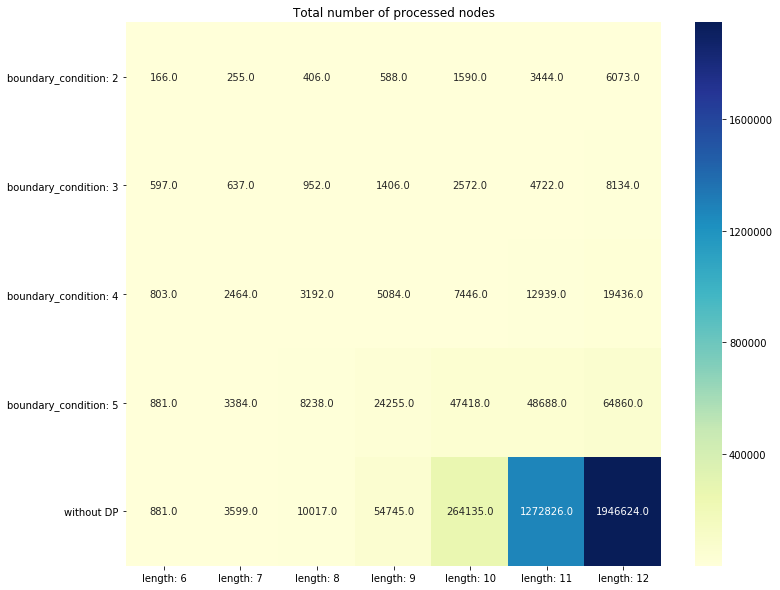

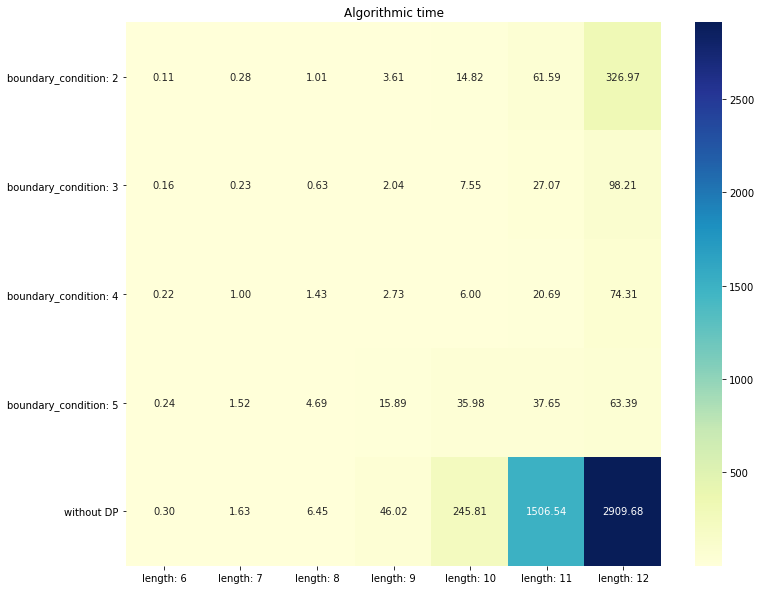

In [5]:
plt.figure(figsize=(12, 10))
seaborn.heatmap(df_nodes, annot=True, cmap="YlGnBu", fmt='.1f')
plt.title('Total number of processed nodes')
plt.show()

plt.figure(figsize=(12, 10))
seaborn.heatmap(df_times, annot=True, cmap="YlGnBu", fmt='.2f')
plt.title('Algorithmic time')
plt.show()

# Time complexity (as function of paths' length)

In [14]:
complexity = []
lengths = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
boundary_conditions = [4, 4, 4, 4, 4, 4, 5, 5, 6, 6, 6, 7, 7]

In [ ]:
for N, bc in zip(lengths, boundary_conditions):

    idx = np.linspace(0, 6.28, N)
    x = np.sin(idx)
    y = np.cos(idx)

    x = AddTime().fit_transform([x])[0]
    y = AddTime().fit_transform([y])[0]

    problem = BnBWarping(x, y, depth=2, norm='l1', p=2., plot_2d=True, boundary_condition=bc,
                         use_dp=True, with_sig_memoization=True, pvar_advanced=False, pth_root=True)

    solver = pybnb.Solver()

    results = solver.solve(problem, log=None, queue_strategy='depth')

    complexity.append(results.wall_time)

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(lengths, complexity, 'b--')
plt.xlabel('length of 2 input paths', fontsize=12)
plt.ylabel('time (in secs)', fontsize=12)
plt.title('Timings for BnB as function of paths lenght', fontsize=14)
plt.show()